<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>

# Tiny ML on Arduino

## Gesture recognition tutorial


## Setup Python Environment

The next cell sets up the dependencies in required for the notebook, run it.


In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.0.0-rc1

# Import the necessary libraries 

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD

# Crafted useful functions

In [2]:
def get_input_output(arr_gestures):
    """
        This function accepts the list of csv file names of one hand (arr_gestures) and perform data preprocessing and normalization and return inputs and outputs data

    Args:
        arr_gestures (list): list of gesture names

    Returns:
        inputs(numpy array): features set
        outputs(numpy array): label set
    """

    SEED = 1337
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

    SAMPLES_PER_GESTURE = 119

    NUM_arr_gestures = len(arr_gestures)

    # create a one-hot encoded matrix that is used in the output
    ONE_HOT_ENCODED_arr_gestures = np.eye(NUM_arr_gestures)

    inputs = []
    outputs = []

    # read each csv file and push an input and output
    for gesture_index in range(NUM_arr_gestures):
        gesture = arr_gestures[gesture_index]
        print(f"Processing index {gesture_index} for gesture '{gesture}'.")

        output = ONE_HOT_ENCODED_arr_gestures[gesture_index]

        df = pd.read_csv("/content/" + gesture + ".csv")

        # calculate the number of gesture recordings in the file
        num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

        print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

        for i in range(num_recordings):
            tensor = []
            for j in range(SAMPLES_PER_GESTURE):
                index = i * SAMPLES_PER_GESTURE + j
                # normalize the input data, between 0 to 1:
                # - acceleration is between: -4 to +4
                # - gyroscope is between: -2000 to +2000
                tensor += [
                    (df["aX"][index] + 4) / 8,
                    (df["aY"][index] + 4) / 8,
                    (df["aZ"][index] + 4) / 8,
                    (df["gX"][index] + 2000) / 4000,
                    (df["gY"][index] + 2000) / 4000,
                    (df["gZ"][index] + 2000) / 4000,
                ]

            inputs.append(tensor)
            outputs.append(output)

    # convert the list to numpy array
    inputs = np.array(inputs)
    outputs = np.array(outputs)

    print("Data set parsing and preparation complete.")

    return inputs, outputs


def splitted_data(inputs, outputs, train_split=0.6, test_split=0.2):
    # Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
    # https://stackoverflow.com/a/37710486/2020087
    num_inputs = len(inputs)
    randomize = np.arange(num_inputs)
    np.random.shuffle(randomize)

    # Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
    inputs = inputs[randomize]
    outputs = outputs[randomize]

    # Split the recordings (group of samples) into three sets: training, testing and validation
    TRAIN_SPLIT = int(train_split * num_inputs)
    TEST_SPLIT = int(test_split * num_inputs + TRAIN_SPLIT)

    inputs_train, inputs_test, inputs_validate = np.split(
        inputs, [TRAIN_SPLIT, TEST_SPLIT]
    )
    outputs_train, outputs_test, outputs_validate = np.split(
        outputs, [TRAIN_SPLIT, TEST_SPLIT]
    )

    print("Data set randomization and splitting complete.")

    return (
        inputs_train,
        inputs_test,
        inputs_validate,
        outputs_train,
        outputs_test,
        outputs_validate,
    )


# Upload Data

1. Open the panel on the left side of Colab by clicking on the **>**
1. Select the files tab
1. Drag `csv` files from your computer to the tab to upload them into colab.

in our cas we have 4 gesture for each hand
- clap
- hi
- down
- up

In [3]:
GESTURES_R = [
    "clap_R",
    "hi_R",
    "up_R",
    "down_R",
]

GESTURES_L = [
    "clap_L",
    "hi_L",
    "up_L",
    "down_L",
]

NUM_GESTURES = len(GESTURES_R)

# Train Neural Network


## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [5]:
inputs_R, outputs_R = get_input_output(GESTURES_R)

print('\n')

inputs_L, outputs_L = get_input_output(GESTURES_L)

Processing index 0 for gesture 'clap_R'.
	There are 39 recordings of the clap_R gesture.
Processing index 1 for gesture 'hi_R'.
	There are 39 recordings of the hi_R gesture.
Processing index 2 for gesture 'up_R'.
	There are 22 recordings of the up_R gesture.
Processing index 3 for gesture 'down_R'.
	There are 20 recordings of the down_R gesture.
Data set parsing and preparation complete.


Processing index 0 for gesture 'clap_L'.
	There are 39 recordings of the clap_L gesture.
Processing index 1 for gesture 'hi_L'.
	There are 39 recordings of the hi_L gesture.
Processing index 2 for gesture 'up_L'.
	There are 22 recordings of the up_L gesture.
Processing index 3 for gesture 'down_L'.
	There are 20 recordings of the down_L gesture.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

- the training set is used to train the model
- the validation set is used to measure how well the model is performing during training
- the testing set is used to test the model after training


In [6]:
(
    inputs_train_R,
    inputs_test_R,
    inputs_validate_R,
    outputs_train_R,
    outputs_test_R,
    outputs_validate_R,
) = splitted_data(inputs_R, outputs_R)

print('\n')

(
    inputs_train_L,
    inputs_test_L,
    inputs_validate_L,
    outputs_train_L,
    outputs_test_L,
    outputs_validate_L,
) = splitted_data(inputs_L, outputs_L)


Data set randomization and splitting complete.


Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.


We change the RMSprop to SGD

RMSprop: is an optimization algorithm that speeds up gradient descent, it is used
to train models based on deep neural networks. RMSProp for “Root Mean Square Propagation”
could be translated as RCEQM for square root mean square error

In [7]:
# taux d'apprentisage
learn_rate = 0.001

# initilisation de la descente du gradient
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

models = [tf.keras.Sequential(), tf.keras.Sequential()]

for idx, m in enumerate(models):
    m.add(tf.keras.layers.Dense(50, activation="relu"))  # relu is used for performance
    m.add(tf.keras.layers.Dense(15, activation="relu"))
    m.add(tf.keras.layers.Dense(NUM_GESTURES, activation="softmax"))
    m.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])
    
    if idx == 0:
        history_R = m.fit(
            inputs_train_R,
            outputs_train_R,
            epochs=50,
            batch_size=1,
            validation_data=(inputs_validate_R, outputs_validate_R),
        )
    else:
        history_L = m.fit(
            inputs_train_L,
            outputs_train_L,
            epochs=50,
            batch_size=1,
            validation_data=(inputs_validate_L, outputs_validate_L),
        )


Epoch 1/50
72/72 [==============================] - 1s 10ms/step - loss: 1.3779 - accuracy: 0.2778 - val_loss: 1.3791 - val_accuracy: 0.2917
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 1.3084 - accuracy: 0.4167 - val_loss: 1.3275 - val_accuracy: 0.5417
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 1.2393 - accuracy: 0.5556 - val_loss: 1.3008 - val_accuracy: 0.3333
Epoch 4/50
72/72 [==============================] - 0s 3ms/step - loss: 1.2363 - accuracy: 0.4583 - val_loss: 1.2456 - val_accuracy: 0.5000
Epoch 5/50
72/72 [==============================] - 0s 3ms/step - loss: 1.1577 - accuracy: 0.5278 - val_loss: 1.1775 - val_accuracy: 0.5417
Epoch 6/50
72/72 [==============================] - 0s 2ms/step - loss: 1.0550 - accuracy: 0.6111 - val_loss: 1.1520 - val_accuracy: 0.5417
Epoch 7/50
72/72 [==============================] - 0s 2ms/step - loss: 1.0353 - accuracy: 0.5556 - val_loss: 1.0651 - val_accuracy: 0.5000
Epoch 8/50
72/72 [=

# Check the models accuracy

Accuracy of the right hand model

In [8]:
score_R = models[0].evaluate(inputs_test_R, outputs_test_R)
print("Test loss:", round(score_R[0], 3))
print("Test accuracy:", round(score_R[1], 3))


Test loss: 0.01
Test accuracy: 0.98


Accuracy of the left hand model

In [9]:
score_L = models[1].evaluate(inputs_test_L, outputs_test_L)
print("Test loss:", round(score_L[0], 3))
print("Test accuracy:", round(score_L[1], 3))

Test loss: 0.015
Test accuracy: 0.97


# Check & plot prediction with test outputs

For the right hand

1/1 [==============================] - 0s 168ms/step
predictions =
 [[0.998 0.    0.001 0.001]
 [0.    0.001 0.999 0.   ]
 [0.997 0.    0.    0.003]
 [0.999 0.    0.001 0.001]
 [0.002 0.088 0.013 0.897]
 [0.    1.    0.    0.   ]
 [0.    0.    0.999 0.   ]
 [0.027 0.012 0.949 0.012]
 [0.    0.982 0.    0.018]
 [0.    0.991 0.    0.009]
 [0.001 0.    0.    0.999]
 [0.    0.999 0.    0.001]
 [0.001 0.    0.    0.999]
 [0.002 0.006 0.001 0.991]
 [0.996 0.    0.001 0.003]
 [0.997 0.    0.    0.003]
 [0.    1.    0.    0.   ]
 [0.    0.996 0.    0.004]
 [0.    0.998 0.    0.002]
 [0.    0.002 0.998 0.   ]
 [0.998 0.    0.001 0.001]
 [0.    0.001 0.998 0.   ]
 [0.    0.999 0.    0.001]
 [0.    0.999 0.    0.001]]
actual =
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0

<ipython-input-11-ee97f98d9967>:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  plt.plot(inputs_test_R, outputs_test_R, "b.", label="Actual")
<ipython-input-11-ee97f98d9967>:12: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  plt.plot(inputs_test_R, predictions_R, "r.", label="Predicted")


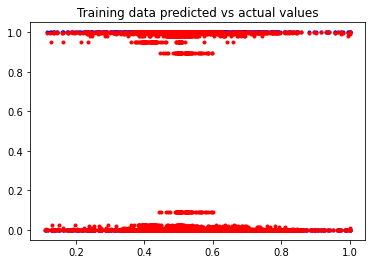

In [11]:
# use the model to predict the test inputs
predictions_R = models[0].predict(inputs_test_R)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions_R, decimals=3))
print("actual =\n", outputs_test_R)

# Plot the predictions along with to the test data
plt.clf()
plt.title("Training data predicted vs actual values")
plt.plot(inputs_test_R, outputs_test_R, "b.", label="Actual")
plt.plot(inputs_test_R, predictions_R, "r.", label="Predicted")
plt.show()


For the left hand

1/1 [==============================] - 0s 48ms/step
predictions =
 [[0.004 0.047 0.    0.949]
 [0.    0.999 0.    0.001]
 [0.998 0.001 0.    0.001]
 [0.998 0.    0.    0.001]
 [0.    1.    0.    0.   ]
 [0.995 0.    0.003 0.002]
 [0.    0.001 0.002 0.997]
 [0.    0.    0.998 0.002]
 [0.002 0.023 0.    0.975]
 [0.998 0.    0.    0.001]
 [0.    0.999 0.    0.001]
 [0.    1.    0.    0.   ]
 [0.001 0.    0.994 0.005]
 [0.    0.998 0.    0.002]
 [0.    0.017 0.    0.982]
 [0.998 0.001 0.    0.001]
 [0.    0.01  0.    0.99 ]
 [0.002 0.806 0.    0.192]
 [0.    0.    0.998 0.002]
 [0.    0.    0.994 0.005]
 [0.998 0.001 0.    0.001]
 [0.999 0.    0.    0.001]
 [0.    0.    0.996 0.004]
 [0.998 0.001 0.    0.001]]
actual =
 [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0.

<ipython-input-12-7b85d97eece2>:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  plt.plot(inputs_test_L, outputs_test_L, "b.", label="Actual")
<ipython-input-12-7b85d97eece2>:12: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  plt.plot(inputs_test_L, predictions_L, "r.", label="Predicted")


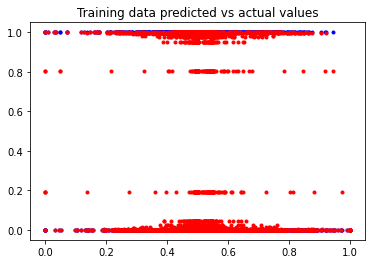

In [12]:
# use the model to predict the test inputs
predictions_L = models[1].predict(inputs_test_L)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions_L, decimals=3))
print("actual =\n", outputs_test_L)

# Plot the predictions along with to the test data
plt.clf()
plt.title("Training data predicted vs actual values")
plt.plot(inputs_test_L, outputs_test_L, "b.", label="Actual")
plt.plot(inputs_test_L, predictions_L, "r.", label="Predicted")
plt.show()


# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.


In [14]:
for idx, m in enumerate(models):
    # Convert the model to the TensorFlow Lite format without quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(m)

    # to optimize size of the model.tflite
    # converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

    tflite_model = converter.convert()

    if idx == 0:
        hand = "R" 
    else: 
        hand ="L"

    # Save the model to disk
    open(f"gesture_model_{hand}.tflite", "wb").write(tflite_model)

    basic_model_size = os.path.getsize(f"gesture_model_{hand}.tflite")
    print(f"Model_{hand} is %d bytes" % basic_model_size)

Model_R is 148352 bytes
Model_L is 148384 bytes


## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.


In [16]:
for idx, m in enumerate(models):
    if idx == 0: 
        !echo "const unsigned char model[] = {" > /content/model_R.h
        !cat gesture_model_R.tflite | xxd -i      >> /content/model_R.h
        !echo "};"                              >> /content/model_R.h
        model ="model_R.h"
    else: 
        !echo "const unsigned char model[] = {" > /content/model_L.h
        !cat gesture_model_L.tflite | xxd -i      >> /content/model_L.h
        !echo "};"                              >> /content/model_L.h
        model ="model_L.h"
        

    model_h_size = os.path.getsize(model)
    print(f"Header file, {model}, is {model_h_size:,} bytes.")
    print(f"\nOpen the side panel (refresh if needed). Double click {model} to download the file.")

Header file, model_R.h.h, is 914,872 bytes.

Open the side panel (refresh if needed). Double click model_R.h to download the file.
Header file, model_L.h.h, is 915,070 bytes.

Open the side panel (refresh if needed). Double click model_L.h to download the file.
